# Import Libraries

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.mask import mask
import json
import matplotlib.pyplot as plt

# Load Fire Data

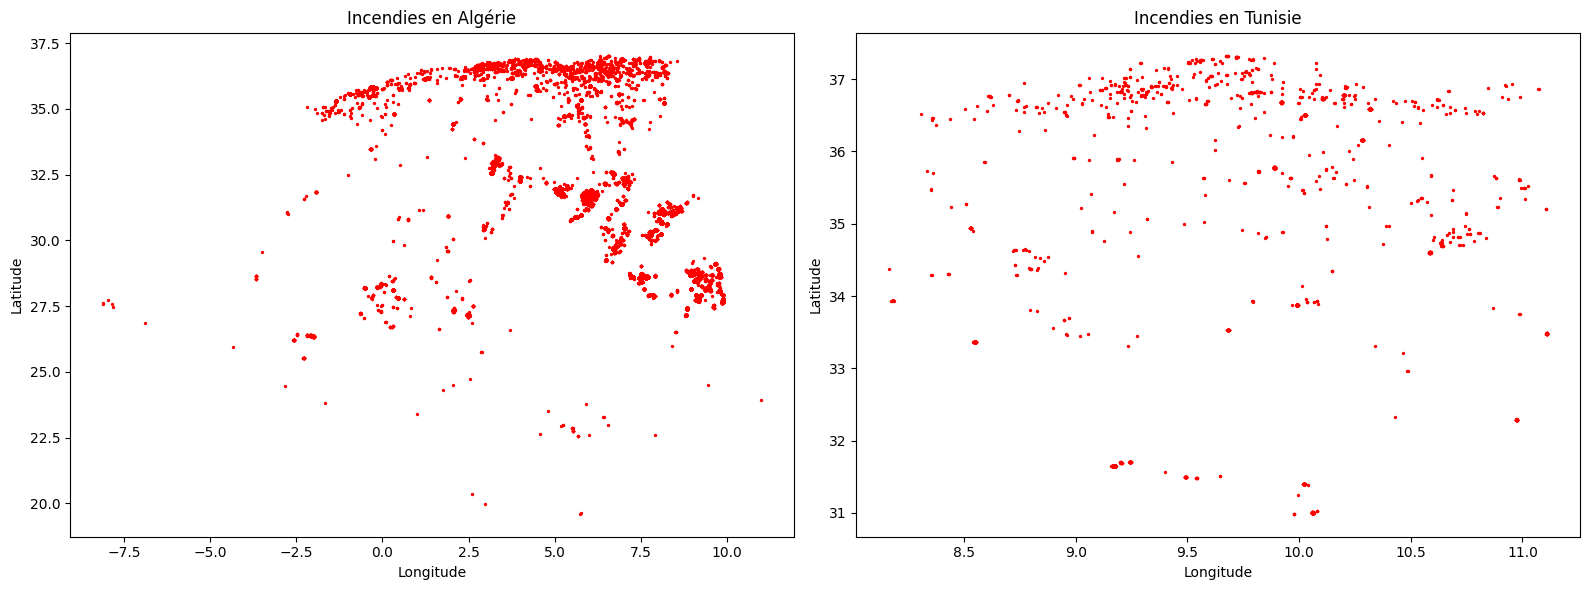

In [ ]:
fp_dza = pd.read_csv(r"../Fire dataset/viirs-jpss1_2024_Algeria.csv")  
fp_tun = pd.read_csv(r"../Fire dataset/viirs-jpss1_2024_Tunisia.csv")

gdf_dza = gpd.GeoDataFrame(
    fp_dza, 
    geometry=[Point(xy) for xy in zip(fp_dza.longitude, fp_dza.latitude)],
    crs="EPSG:4326"
)

gdf_tun = gpd.GeoDataFrame(
    fp_tun,
    geometry=[Point(xy) for xy in zip(fp_tun.longitude, fp_tun.latitude)],
    crs="EPSG:4326"
)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Algérie
ax[0].scatter(fp_dza["longitude"], fp_dza["latitude"], s=2, c="red")
ax[0].set_title("Incendies en Algérie")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

# Tunisie
ax[1].scatter(fp_tun["longitude"], fp_tun["latitude"], s=2, c="red")
ax[1].set_title("Incendies en Tunisie")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()


# Data Analysis and Visualization

In [ ]:
import seaborn as sns
def analyse_fire(fp):
    print("Colonnes :", list(fp.columns))
    print("Taille :", fp.shape)
    print("Types de données :")
    print(fp.dtypes.unique())
    print("Valeurs manquantes :")
    print(fp.isna().sum())
    print("-" * 60)
    num_cols = ['bright_ti4', 'bright_ti5', 'frp', 'scan', 'track']
    print("STATISTIQUES NUMÉRIQUES")
    print(fp[num_cols].describe())
    # Distribution par date
    fp['acq_date'] = pd.to_datetime(fp['acq_date'])
    fp['year_month'] = fp['acq_date'].dt.to_period('M')
    plt.figure(figsize=(12,6))
    fp['year_month'].value_counts().sort_index().plot(kind='bar')
    plt.title("Nombre de points d’incendie par mois")
    plt.xlabel("Mois")
    plt.ylabel("Nombre d’incendies détectés")
    plt.tight_layout()
    plt.show()
    # Analyse de la confiance
    plt.figure(figsize=(8,5))
    sns.countplot(x='confidence', data=fp)
    plt.title("Distribution du niveau de confiance des détections")
    plt.xlabel("Confiance")
    plt.ylabel("Nombre de détections")
    plt.show()

    # Relation entre température et puissance
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=fp, x='bright_ti4', y='frp', hue='confidence', alpha=0.6)
    plt.title("Puissance (FRP) vs Température de brillance (TI4)")
    plt.xlabel("Température Bright_Ti4 (Kelvin)")
    plt.ylabel("Puissance du feu (FRP)")
    plt.show()

    # Répartition jour/nuit
    plt.figure(figsize=(6,5))
    sns.countplot(x='daynight', data=fp)
    plt.title("Détections jour vs nuit")
    plt.show()

    # carte de chaleur simple 
    plt.figure(figsize=(8,8))
    plt.hexbin(fp['longitude'], fp['latitude'], gridsize=60, cmap='hot', bins='log')
    plt.colorbar(label='Nombre de points détectés')
    plt.title("Carte de densité des incendies (approximation)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
analyse_fire(fp_dza)
print("-"*100)
analyse_fire(fp_tun)


# Fire Data Visualization

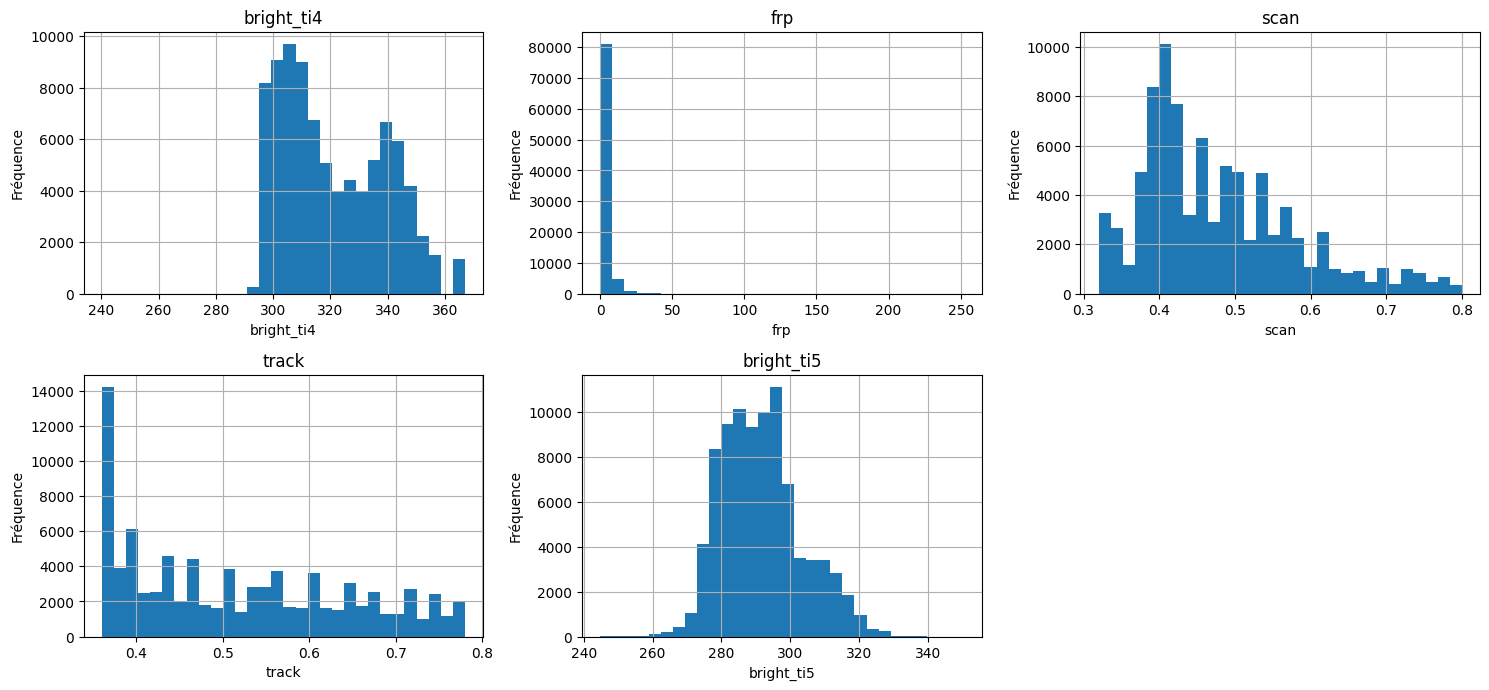

In [13]:

columns = [
    "bright_ti4",
    "frp",
    "scan",
    "track",
    "bright_ti5"
]
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    fp_dza[col].dropna().hist(bins=30)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()


# Additional Visualizations

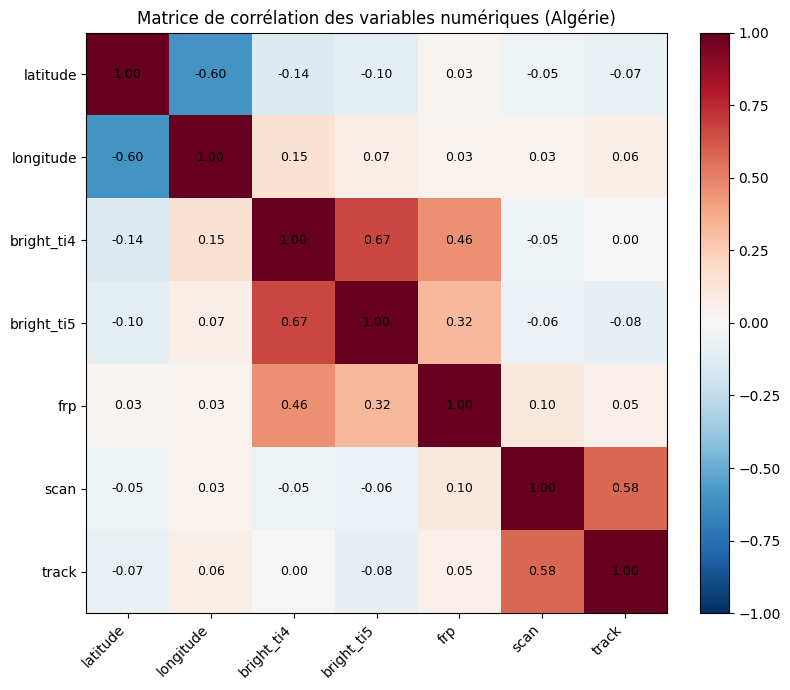

In [ ]:

columns = [
    "latitude",
    "longitude",
    "bright_ti4",
    "bright_ti5",
    "frp",
    "scan",
    "track"
]
corr_matrix = fp_dza[columns].corr()
plt.figure(figsize=(9, 7))
im = plt.imshow(corr_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(columns)), columns, rotation=45, ha="right")
plt.yticks(range(len(columns)), columns)
for i in range(len(columns)):
    for j in range(len(columns)):
        value = corr_matrix.iloc[i, j]
        plt.text(j, i, f"{value:.2f}",
                 ha="center", va="center", color="black", fontsize=9)
plt.title("Matrice de corrélation des variables numériques (Algérie)")
plt.tight_layout()
plt.show()


# Data Processing and Export

In [ ]:
import pandas as pd
def clean_fire_data(df):
    print(f"Nombre de lignes initial: {len(df)}")
    df_clean = df.copy()
    df_clean = df_clean.drop_duplicates()
    print(f"Après suppression des doublons: {len(df_clean)}")

    df_clean = df_clean[
        (df_clean['latitude'] >= -90) & 
        (df_clean['latitude'] <= 90)
    ]
    df_clean = df_clean[
        (df_clean['longitude'] >= -180) & 
        (df_clean['longitude'] <= 180)
    ]
    print(f"Après vérification des coordonnées: {len(df_clean)}")
    critical_columns = ['latitude', 'longitude', 'acq_date', 'bright_ti5',"bright_ti4"]
    df_clean = df_clean.dropna(subset=critical_columns)
    print(f"Après suppression des valeurs manquantes critiques: {len(df_clean)}")
    if 'confidence' in df_clean.columns:
        df_clean = df_clean[df_clean['confidence'].isin(['n', 'h'])]
        print(f"Après filtrage par confiance (n, h): {len(df_clean)}")
    if 'frp' in df_clean.columns:
        df_clean = df_clean[df_clean['frp'] > 0]
        Q1 = df_clean['frp'].quantile(0.25)
        Q3 = df_clean['frp'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[
            (df_clean['frp'] >= lower_bound) & 
            (df_clean['frp'] <= upper_bound)
        ]
        df_clean = df_clean[df_clean["type"]==0]
        print(f"Après nettoyage FRP: {len(df_clean)}")
    for col in ['bright_ti4', 'bright_ti5']:
        if col in df_clean.columns:
            df_clean = df_clean[df_clean[col].between(270, 500)]
            print(f"Après nettoyage {col} : {len(df_clean)}")
    df_clean['acq_date'] = pd.to_datetime(df_clean['acq_date'], errors='coerce')
    df_clean = df_clean.dropna(subset=['acq_date'])
    # df_clean["class"] = (df_clean["type"] != 2).astype(int)
    df_clean = df_clean[
        (df_clean['acq_date'].dt.year == 2024)
    ]
    if 'acq_time' in df_clean.columns:
        df_clean['acq_time'] = df_clean['acq_time'].astype(str).str.zfill(4)
        df_clean['datetime'] = pd.to_datetime(
            df_clean['acq_date'].dt.strftime('%Y-%m-%d') + ' ' +
            df_clean['acq_time'].str[:2] + ':' +
            df_clean['acq_time'].str[2:], errors='coerce'
        )
        df_clean.dropna(subset=['datetime'], inplace=True)
    print(f"Après validation des dates: {len(df_clean)}")
    df_clean['date_only'] = df_clean['acq_date'].dt.date
    df_clean = df_clean.drop_duplicates(
        subset=['latitude', 'longitude'],
        keep='first'
    )
    df_clean = df_clean.drop(['acq_date', 'acq_time',"bright_ti4","scan","track","confidence","version","bright_ti5","frp","daynight"], axis=1)#,"datetime","type"
    df_clean = df_clean.drop('date_only', axis=1)
    df_clean = df_clean.drop('satellite', axis=1)
    df_clean = df_clean.drop('instrument', axis=1)
    print(f"Après suppression des doublons spatio-temporels: {len(df_clean)}")
    print(f"\nRésumé du nettoyage:")
    print(f"Lignes supprimées: {len(df) - len(df_clean)}")
    print(f"Pourcentage conservé: {len(df_clean)/len(df)*100:.2f}%")

    return df_clean
df1 = pd.read_csv("..\\Fire dataset\\viirs-jpss1_2024_Algeria.csv")
df2 = pd.read_csv("..\\Fire dataset\\viirs-jpss1_2024_Tunisia.csv")
result_df = clean_fire_data(df2)
result_df.to_csv("..\\fire_test\\viirs-jpss1_2024_Tunisia_cleaned.csv", index=False)

# combined = pd.concat([df1, df2], ignore_index=True)
# df_cleaned = clean_fire_data(combined)
# df_cleaned.to_csv("..\\Fire dataset\\viirs-jpss1_2024_cleaned.csv", index=False)
